# Fourier Transform and Gaussian smoothing technique: Do the neural activity recorded show event-related desynchronisation?

In [1]:
# Libraries used

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.fft import fft
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

In [2]:

# Loading dataset
neuro_csv = pd.read_csv('/content/20241127_brainwaves.csv')

pd.set_option("display.max_columns", None)
neuro_csv.head()

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,Alpha_AF7,Alpha_AF8,Alpha_TP10,Beta_TP9,Beta_AF7,Beta_AF8,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10,AUX_RIGHT,Mellow,Concentration,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Delta_PCA,Theta_PCA,Alpha_PCA,Beta_PCA,Gamma_PCA,Delta_Median,Theta_Median,Alpha_Median,Beta_Median,Gamma_Median
0,2024-06-13 14:10:20.376,0.01898,0.901503,0.509348,0.5102,0.24,-0.579461,0.365699,0.380469,0.580544,-0.044486,0.34242,0.384023,1.178329,0.183695,0.815397,1.082866,0.995981,-0.268507,0.869319,0.575177,800.21980,730.10986,751.46520,769.59705,772.01465,0.0,100.0,-0.274109,0.195129,0.956726,-6.258087,17.413483,-13.921814,1.0,2.0,1.0,1.0,2.0,65.0,-0.535707,-1.100514,-1.61249,4.059653,4.834012,0.509775,0.302849,0.363222,0.949131,0.722248
1,2024-06-13 14:10:20.378,0.01898,0.901503,0.509348,0.5102,0.24,-0.579461,0.365699,0.380469,0.580544,-0.044486,0.34242,0.384023,1.178329,0.183695,0.815397,1.082866,0.995981,-0.268507,0.869319,0.575177,800.62270,739.78020,756.70330,773.22345,722.05130,0.0,100.0,-0.274109,0.195129,0.956726,-6.258087,17.413483,-13.921814,1.0,2.0,1.0,1.0,2.0,65.0,-0.535707,-1.100514,-1.61249,4.059653,4.834012,0.509775,0.302849,0.363222,0.949131,0.722248
2,2024-06-13 14:10:20.378,0.01898,0.901503,0.509348,0.5102,0.24,-0.579461,0.365699,0.380469,0.580544,-0.044486,0.34242,0.384023,1.178329,0.183695,0.815397,1.082866,0.995981,-0.268507,0.869319,0.575177,804.65204,745.82416,749.45056,793.77290,618.49817,0.0,100.0,-0.274109,0.195129,0.956726,-6.258087,17.413483,-13.921814,1.0,2.0,1.0,1.0,2.0,65.0,-0.535707,-1.100514,-1.61249,4.059653,4.834012,0.509775,0.302849,0.363222,0.949131,0.722248
3,2024-06-13 14:10:20.378,0.01898,0.901503,0.509348,0.5102,0.24,-0.579461,0.365699,0.380469,0.580544,-0.044486,0.34242,0.384023,1.178329,0.183695,0.815397,1.082866,0.995981,-0.268507,0.869319,0.575177,810.69600,740.98900,750.25640,807.87550,797.39930,0.0,100.0,-0.274109,0.195129,0.956726,-6.258087,17.413483,-13.921814,1.0,2.0,1.0,1.0,2.0,65.0,-0.535707,-1.100514,-1.61249,4.059653,4.834012,0.509775,0.302849,0.363222,0.949131,0.722248
4,2024-06-13 14:10:20.379,0.01898,0.901503,0.509348,0.5102,0.24,-0.579461,0.365699,0.380469,0.580544,-0.044486,0.34242,0.384023,1.178329,0.183695,0.815397,1.082866,0.995981,-0.268507,0.869319,0.575177,822.78390,748.24176,735.75090,812.30770,1135.05490,0.0,100.0,-0.274109,0.195129,0.956726,-6.258087,17.413483,-13.921814,1.0,2.0,1.0,1.0,2.0,65.0,-0.535707,-1.100514,-1.61249,4.059653,4.834012,0.509775,0.302849,0.363222,0.949131,0.722248


In [3]:

# Selecting the columns of interest
powerbands = neuro_csv[['Alpha_Median', 'Beta_Median', 'Delta_Median', 'Gamma_Median', 'Theta_Median']]

# Melting the DataFrame for easier plotting with Seaborn
melted_data = powerbands.melt(var_name='Power Band', value_name='Power')

# Converting 'Power' column to numeric, handling errors
melted_data['Power'] = pd.to_numeric(melted_data['Power'], errors='coerce')

# Dropping rows with NaN values in 'Power' column, if any
melted_data = melted_data.dropna(subset=['Power'])


In [4]:
# Simulating some brainwave data (e.g., power values for each band)
time_points = np.linspace(0, 10, 1000)  # 10 seconds sampled at 100 Hz
delta_median = np.random.normal(0, 0.5, len(time_points))  # Delta power
theta_median = np.random.normal(0, 0.5, len(time_points))  # Theta power
alpha_median = np.random.normal(0, 0.5, len(time_points))  # Alpha power
beta_median = np.random.normal(0, 0.5, len(time_points))   # Beta power
gamma_median = np.random.normal(0, 0.5, len(time_points))  # Gamma power

# Simulating brainwave signals over time
brainwave_data = {
    'Time': time_points,
    'Delta_Median': delta_median,
    'Theta_Median': theta_median,
    'Alpha_Median': alpha_median,
    'Beta_Median': beta_median,
    'Gamma_Median': gamma_median
}

# Creating a dataframe
brainwave_data = pd.DataFrame(brainwave_data)


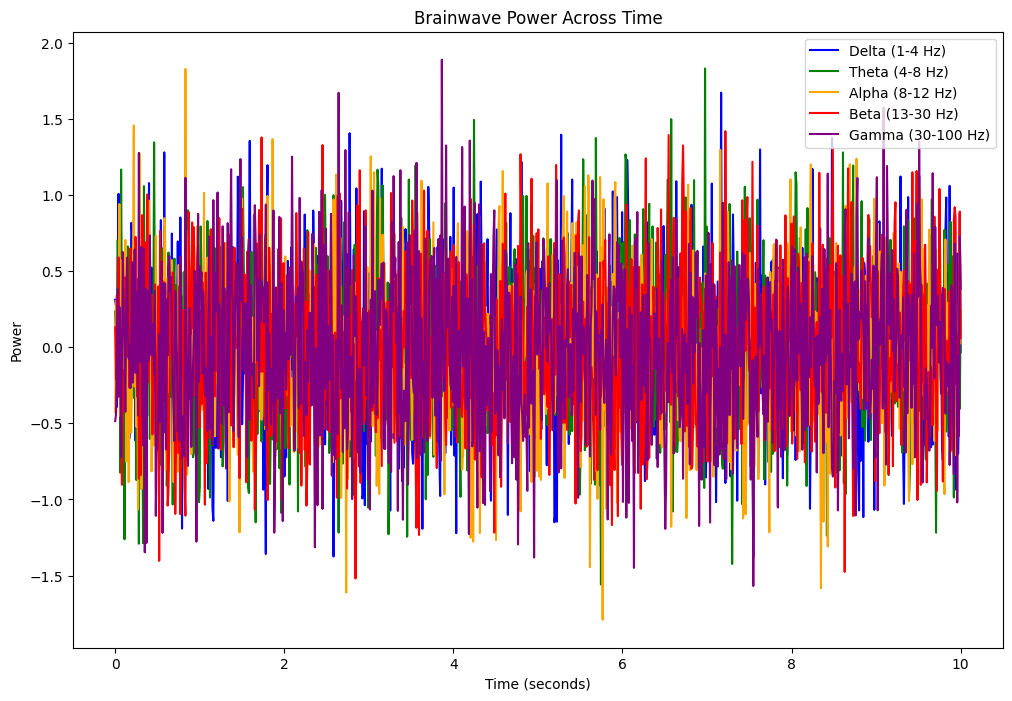

In [5]:
# Visualising brainwave power across time

plt.figure(figsize=(12, 8))
# Corrected keys to match the brainwave_data dictionary:
plt.plot(brainwave_data['Time'], brainwave_data['Delta_Median'], label='Delta (1-4 Hz)', color='blue')
plt.plot(brainwave_data['Time'], brainwave_data['Theta_Median'], label='Theta (4-8 Hz)', color='green')
plt.plot(brainwave_data['Time'], brainwave_data['Alpha_Median'], label='Alpha (8-12 Hz)', color='orange')
plt.plot(brainwave_data['Time'], brainwave_data['Beta_Median'], label='Beta (13-30 Hz)', color='red')
plt.plot(brainwave_data['Time'], brainwave_data['Gamma_Median'], label='Gamma (30-100 Hz)', color='purple')

plt.xlabel('Time (seconds)')
plt.ylabel('Power')
plt.title('Brainwave Power Across Time')
plt.legend()
plt.grid(False)
plt.show()

Since this was not very telling of what to look for, I tried changing my approach:

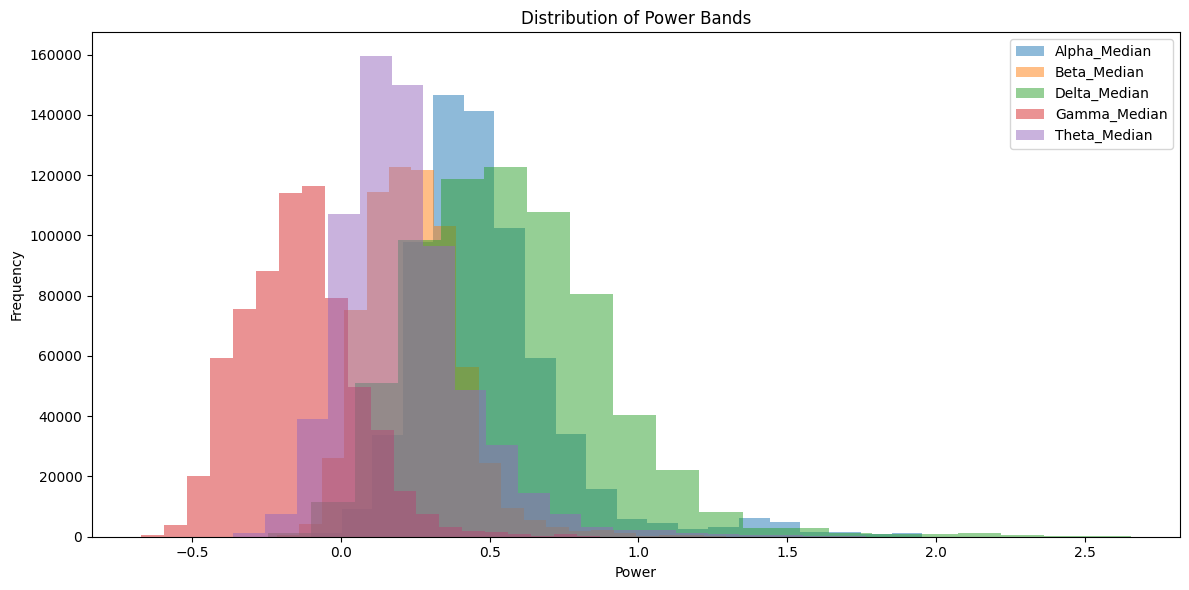

In [6]:
# Histograms to visualise the different neural waves, and observe their trend

plt.figure(figsize=(12, 6))
for powerbands in ['Alpha_Median', 'Beta_Median', 'Delta_Median', 'Gamma_Median', 'Theta_Median']:
    # Convert the column to numeric, handling errors
    numeric_data = pd.to_numeric(neuro_csv[powerbands], errors='coerce')

    # Dropping NaN values
    numeric_data = numeric_data.dropna()

    plt.hist(numeric_data, bins=20, alpha=0.5, label=powerbands)  # Adjust bins and alpha as needed
plt.xlabel('Power')
plt.ylabel('Frequency')
plt.title('Distribution of Power Bands')
plt.legend()
plt.tight_layout()
plt.show()

Perfoming FFT for the different bands

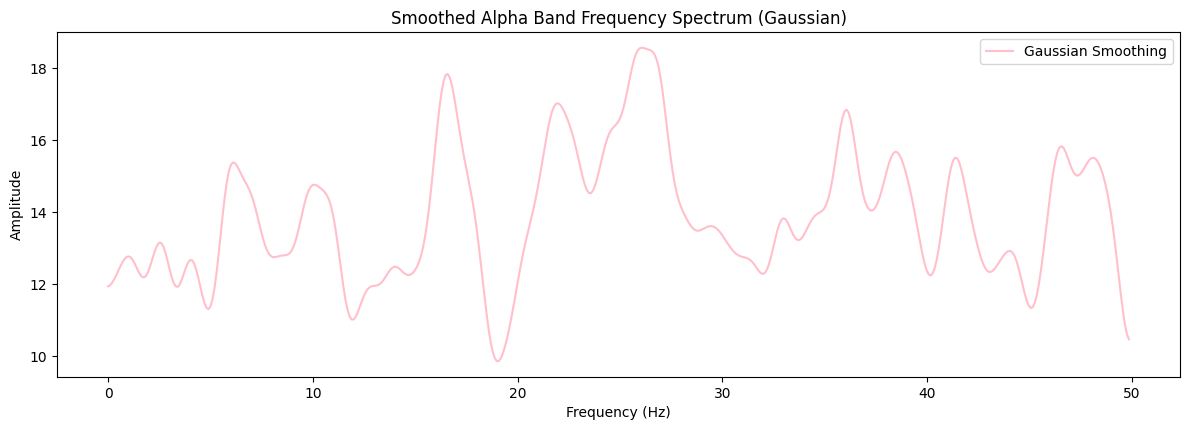

In [7]:
# Perform FFT for Alpha waves
N = len(brainwave_data['Alpha_Median'])
T = time_points[1] - time_points[0]  # Sampling period

alpha_median_array = brainwave_data['Alpha_Median'].to_numpy()

# Compute FFT
alpha_fft = fft(alpha_median_array)  # Pass the NumPy array here
frequencies = np.fft.fftfreq(N, T)

# Only take the positive frequencies and their corresponding magnitudes
positive_freqs = frequencies[:N//2]
alpha_fft_mag = np.abs(alpha_fft[:N//2])

# Apply Gaussian smoothing (sigma controls the degree of smoothing)
smoothed_alpha_fft_mag_gaussian = gaussian_filter1d(alpha_fft_mag, sigma=5)

# Plotting Gaussian smoothed data
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(positive_freqs, smoothed_alpha_fft_mag_gaussian, color='pink', label='Gaussian Smoothing')
plt.title('Smoothed Alpha Band Frequency Spectrum (Gaussian)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()


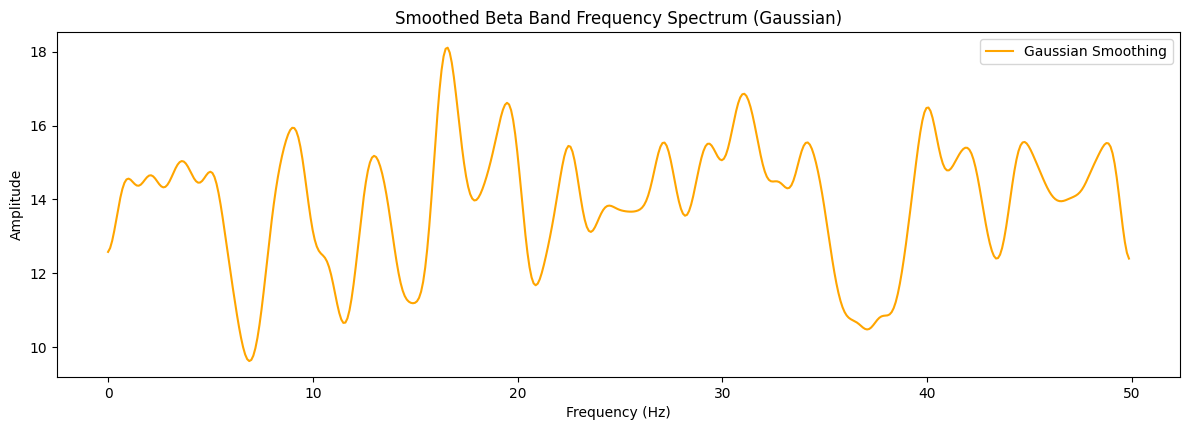

In [8]:
# Perform FFT for Beta waves
N = len(brainwave_data['Beta_Median'])
T = time_points[1] - time_points[0]  # Sampling period


beta_median_array = brainwave_data['Beta_Median'].to_numpy()

# Compute FFT
beta_fft = fft(beta_median_array)  # Pass the NumPy array here
frequencies = np.fft.fftfreq(N, T)

# Only take the positive frequencies and their corresponding magnitudes
positive_freqs = frequencies[:N//2]
beta_fft_mag = np.abs(beta_fft[:N//2])

# Apply Gaussian smoothing (sigma controls the degree of smoothing)
smoothed_beta_fft_mag_gaussian = gaussian_filter1d(beta_fft_mag, sigma=5)

# Plot Gaussian smoothed data
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(positive_freqs, smoothed_beta_fft_mag_gaussian, color='orange', label='Gaussian Smoothing')
plt.title('Smoothed Beta Band Frequency Spectrum (Gaussian)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()

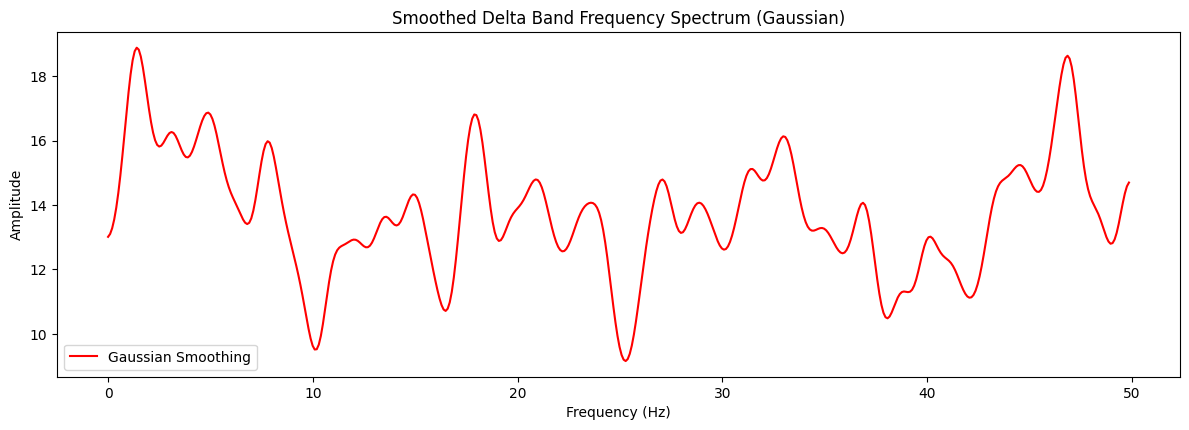

In [9]:
# Perform FFT for Delta waves
N = len(brainwave_data['Delta_Median'])
T = time_points[1] - time_points[0]  # Sampling period

delta_median_array = brainwave_data['Delta_Median'].to_numpy()

# Compute FFT
delta_fft = fft(delta_median_array)  # Pass the NumPy array here
frequencies = np.fft.fftfreq(N, T)

# Only take the positive frequencies and their corresponding magnitudes
positive_freqs = frequencies[:N//2]
delta_fft_mag = np.abs(delta_fft[:N//2])

# Apply Gaussian smoothing (sigma controls the degree of smoothing)
smoothed_delta_fft_mag_gaussian = gaussian_filter1d(delta_fft_mag, sigma=5)

# Plot Gaussian smoothed data
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(positive_freqs, smoothed_delta_fft_mag_gaussian, color='red', label='Gaussian Smoothing')
plt.title('Smoothed Delta Band Frequency Spectrum (Gaussian)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()

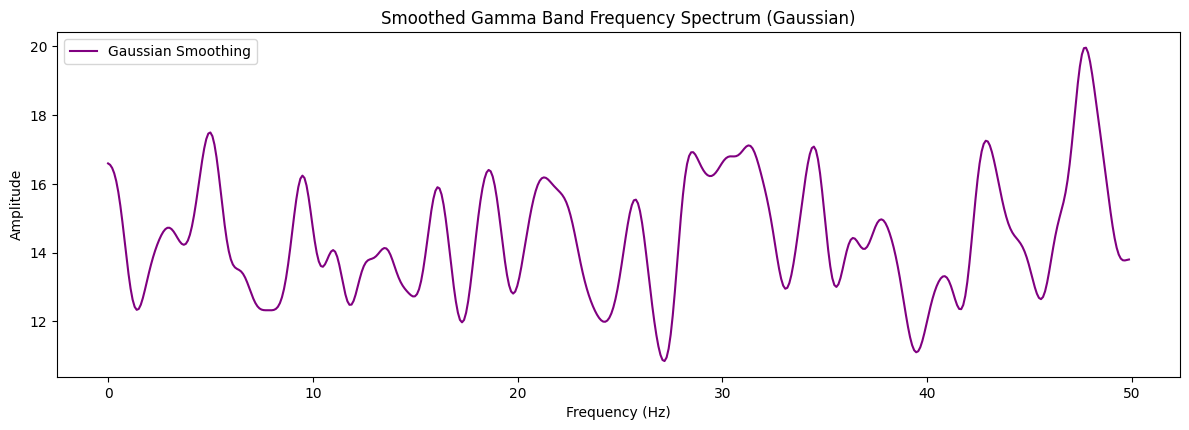

In [10]:
# Perform FFT for Gamma waves
N = len(brainwave_data['Gamma_Median'])
T = time_points[1] - time_points[0]  # Sampling period

gamma_median_array = brainwave_data['Gamma_Median'].to_numpy()

# Compute FFT
gamma_fft = fft(gamma_median_array)  # Pass the NumPy array here
frequencies = np.fft.fftfreq(N, T)

# Only take the positive frequencies and their corresponding magnitudes
positive_freqs = frequencies[:N//2]
gamma_fft_mag = np.abs(gamma_fft[:N//2])

# Apply Gaussian smoothing (sigma controls the degree of smoothing)
smoothed_gamma_fft_mag_gaussian = gaussian_filter1d(gamma_fft_mag, sigma=5)


# Plot Gaussian smoothed data
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(positive_freqs, smoothed_gamma_fft_mag_gaussian, color='purple', label='Gaussian Smoothing')
plt.title('Smoothed Gamma Band Frequency Spectrum (Gaussian)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()

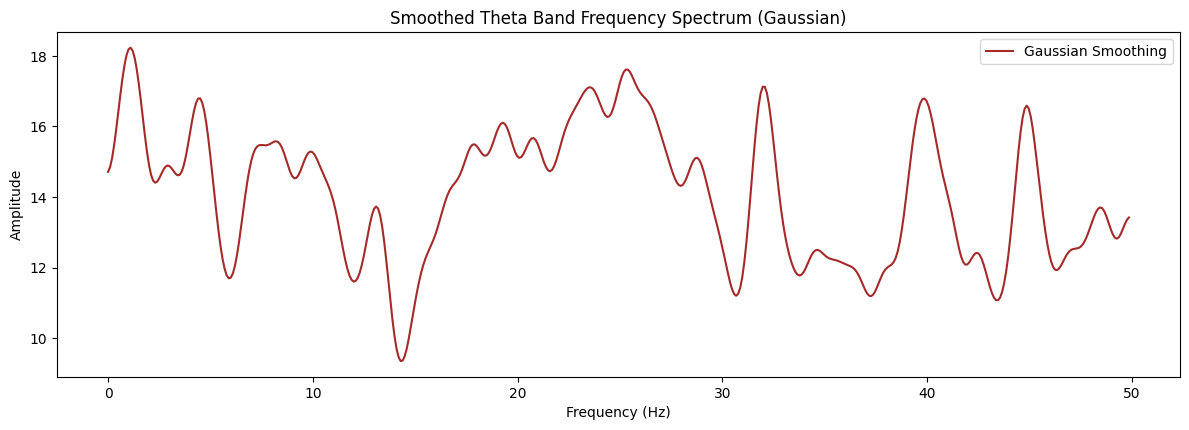

In [11]:
# Perform FFT for Theta waves
N = len(brainwave_data['Theta_Median'])
T = time_points[1] - time_points[0]  # Sampling period

theta_median_array = brainwave_data['Theta_Median'].to_numpy()

# Compute FFT
theta_fft = fft(theta_median_array)  # Pass the NumPy array here
frequencies = np.fft.fftfreq(N, T)

# Only take the positive frequencies and their corresponding magnitudes
positive_freqs = frequencies[:N//2]
theta_fft_mag = np.abs(theta_fft[:N//2])

# Apply Gaussian smoothing (sigma controls the degree of smoothing)
smoothed_theta_fft_mag_gaussian = gaussian_filter1d(theta_fft_mag, sigma=5)

# Plot Gaussian smoothed data
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(positive_freqs, smoothed_theta_fft_mag_gaussian, color='brown', label='Gaussian Smoothing')
plt.title('Smoothed Theta Band Frequency Spectrum (Gaussian)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()

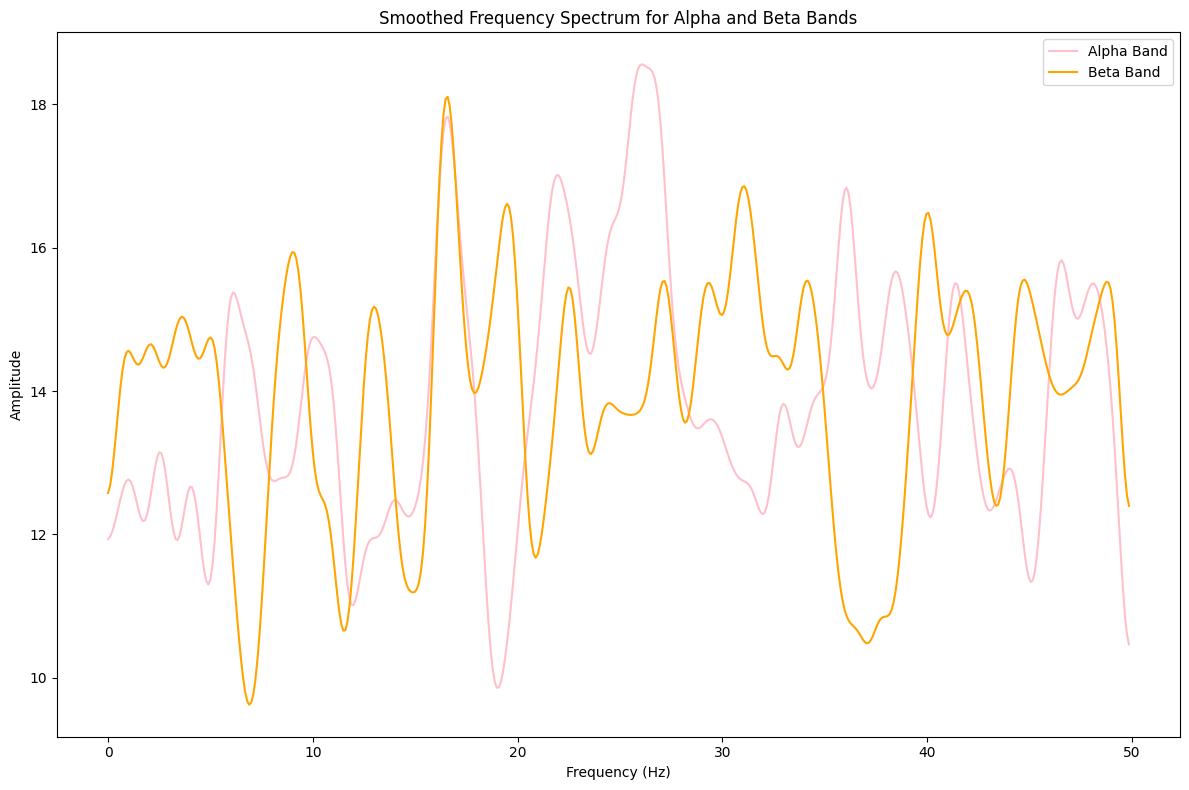

In [12]:
# Overlapping alpha and beta waves to observe the presence/absence of ERD/ERS

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.ndimage import gaussian_filter1d

# Time points and sampling period
N = len(brainwave_data['Theta_Median'])
T = time_points[1] - time_points[0]  # Sampling period

alpha_median_array = brainwave_data['Alpha_Median'].to_numpy()
beta_median_array = brainwave_data['Beta_Median'].to_numpy()

# Compute FFT for each band
alpha_fft = fft(alpha_median_array)
beta_fft = fft(beta_median_array)

# Frequency values
frequencies = np.fft.fftfreq(N, T)

# Only take the positive frequencies
positive_freqs = frequencies[:N//2]

# Get the magnitudes of the FFT for each band
alpha_fft_mag = np.abs(alpha_fft[:N//2])
beta_fft_mag = np.abs(beta_fft[:N//2])


# Apply Gaussian smoothing
sigma = 5
smoothed_alpha_fft_mag = gaussian_filter1d(alpha_fft_mag, sigma=sigma)
smoothed_beta_fft_mag = gaussian_filter1d(beta_fft_mag, sigma=sigma)


# Plotting
plt.figure(figsize=(12, 8))
plt.plot(positive_freqs, smoothed_alpha_fft_mag, label='Alpha Band', color='pink')
plt.plot(positive_freqs, smoothed_beta_fft_mag, label='Beta Band', color='orange')
plt.title('Smoothed Frequency Spectrum for Alpha and Beta Bands')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()
